In [1]:
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime

In [2]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [41]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")#chunks={'time':1})

In [42]:
mt_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"
blobs = xr.open_dataset(f"{mt_path}/01860503-01901020_ocetrac-labels-region.nc")
labels = blobs.blobs
df = pd.read_pickle(f"{mt_path}/01860503-01901020_mhw-metrics-region.pkl")

In [43]:
event_label = 25
df.loc[df.id==event_label].date.values[-1]

array(['0186-07-26', '0186-07-27', '0186-07-28', '0186-07-29',
       '0186-07-30', '0186-07-31', '0186-08-01', '0186-08-02',
       '0186-08-03', '0186-08-04', '0186-08-05', '0186-08-06',
       '0186-08-07', '0186-08-08', '0186-08-09', '0186-08-10',
       '0186-08-11', '0186-08-12', '0186-08-13', '0186-08-14',
       '0186-08-15', '0186-08-16', '0186-08-17', '0186-08-18',
       '0186-08-19', '0186-08-20', '0186-08-21', '0186-08-22',
       '0186-08-23'], dtype='datetime64[D]')

In [44]:
event = (labels==25).any("time")
event

<xarray.DataArray 'blobs' (yh: 193, xh: 547)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * xh       (xh) float64 -137.9 -137.7 -137.4 ... -0.7242 -0.4758 -0.2274
  * yh       (yh) float64 8.222 8.469 8.716 8.963 ... 48.43 48.59 48.76 48.92

In [45]:
ds = xr.merge([ds, event], join="inner")
ds

<xarray.Dataset>
Dimensions:                         (time: 1460, xh: 269, yh: 130, zl: 75,
                                     xq: 270, yq: 131)
Coordinates:
  * time                            (time) object 0186-01-01 12:00:00 ... 018...
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
  * zl                              (zl) float64 1.0 3.0 ... 3.591e+03 5.111e+03
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
Data variables: (12/23)
    S_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_adx                           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 130, 270), meta=np.ndarray>
    T_ady                           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 131, 269), meta=np.ndarray>
    Th_tendency_vert_remap          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    boundary_forcing_h_tendency     (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    ...                              ...
    umo                             (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 130, 270), meta=np.ndarray>
    vert_remap_h_tendency           (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    vmo                             (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 131, 269), meta=np.ndarray>
    volcello                        (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    wfo                             (time, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
    blobs                           (yh, xh) bool False False ... False False
Attributes:
    filename:          01860101.ocean_daily.nc
    title:             CM4_piControl_C_restartyear186
    associated_files:  areacello: 01860101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           Wed Mar 20 15:17:19 2024: ncks -v S_advection_xy -d xh...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [46]:
# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds.sel(time=ds.time[1:]), snap])
ds

<xarray.Dataset>
Dimensions:                         (time: 1459, xh: 269, yh: 130, zl: 75,
                                     xq: 270, yq: 131, time_bounds: 1460)
Coordinates:
  * time                            (time) object 0186-01-02 12:00:00 ... 018...
  * xh                              (xh) float64 -137.9 -137.7 ... -70.16 -69.91
  * yh                              (yh) float64 10.2 10.44 ... 38.87 39.07
  * zl                              (zl) float64 1.0 3.0 ... 3.591e+03 5.111e+03
  * xq                              (xq) float64 -137.8 -137.6 ... -69.76 -69.51
  * yq                              (yq) float64 10.32 10.56 ... 39.16 39.36
  * time_bounds                     (time_bounds) object 0186-01-02 00:00:00 ...
Data variables: (12/28)
    S_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_advection_xy                  (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    T_adx                           (time, zl, yh, xq) float32 dask.array<chunksize=(1, 75, 130, 270), meta=np.ndarray>
    T_ady                           (time, zl, yq, xh) float32 dask.array<chunksize=(1, 75, 131, 269), meta=np.ndarray>
    Th_tendency_vert_remap          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    boundary_forcing_h_tendency     (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    ...                              ...
    blobs                           (yh, xh) bool False False ... False False
    rhopot2_bounds                  (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thetao_bounds                   (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    thkcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    volcello_bounds                 (time_bounds, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 130, 269), meta=np.ndarray>
    zos_bounds                      (time_bounds, yh, xh) float32 dask.array<chunksize=(1, 130, 269), meta=np.ndarray>
Attributes:
    filename:          01860101.ocean_daily.nc
    title:             CM4_piControl_C_restartyear186
    associated_files:  areacello: 01860101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    history:           Wed Mar 20 15:17:19 2024: ncks -v S_advection_xy -d xh...
    NCO:               netCDF Operators version 5.0.1 (Homepage = http://nco....

In [47]:
ds = xr.merge([static,ds],join='inner')

In [48]:
def add_estimated_layer_interfaces(ds):
    return ds.assign_coords({"zi": xr.DataArray(
        np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
        dims=('zi',)
    )})

In [49]:
ds = add_estimated_layer_interfaces(ds)

In [50]:
# Add core coordinates of static to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
    "lon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "lat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
    "xq": xr.DataArray(ds["xq"].values, dims=('xq',)),
    "yq": xr.DataArray(ds["yq"].values, dims=('yq',)),
    "deptho": xr.DataArray(ds["deptho"].values, dims=('yh', 'xh',)),
    "geolon": xr.DataArray(ds["geolon"].values, dims=('yh', 'xh',)),
    "geolat": xr.DataArray(ds["geolat"].values, dims=('yh', 'xh',)),
    "geolon_c": xr.DataArray(ds["geolon_c"].values, dims=('yq', 'xq',)),
    "geolat_c": xr.DataArray(ds["geolat_c"].values, dims=('yq', 'xq',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
}
#'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}
#'Z': {'center': 'zl', 'outer': 'zl'}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}

ds['tos'] = ds['thetao'].isel(zl=0)
#ds['sos'] = ds['so'].isel(zl=0)

grid = xgcm.Grid(ds.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)

In [51]:
wm = xwmt.WaterMass(grid)

In [52]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
del budgets_dict['salt']['lhs']
del budgets_dict['salt']['rhs']

In [53]:
xbudget.collect_budgets(grid, budgets_dict)

In [54]:
budgets_dict;

(10.0, 38.0)

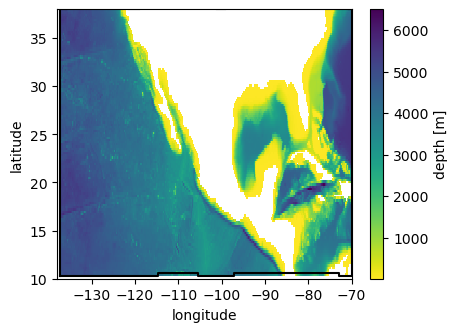

In [55]:
import numpy as np
import regionate
import matplotlib.pyplot as plt

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "MANSO"
#lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
#lons = np.arange([-138, 0, 3.4])
lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
#lats = np.arange(8, 49, 1)
lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
#lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
manso_region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(manso_region.lons), regionate.loop(manso_region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");
plt.xlim(np.min(lons), np.max(lons))
plt.ylim(np.min(lats), np.max(lats))

#plt.xlim(-200,5)
#plt.ylim(-10,80)

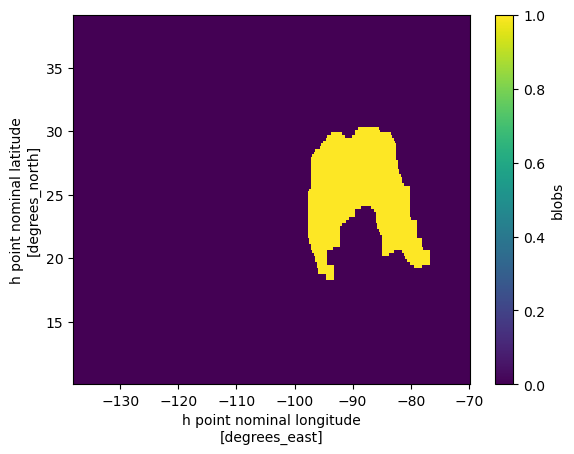

In [56]:
ds.blobs.plot()

In [57]:
import warnings

lam = "heat"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        ds.blobs #instead of manso_region.mask
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True)
    wmtcalc = wmb.wmt
    wmtcalc

In [58]:
# wmb.wmt.where(
#     (wmb.wmt.time > cftime.datetime(186, 7, 1, calendar="noleap")) &
#     (wmb.wmt.time < cftime.datetime(186, 10, 1, calendar="noleap")), 0
# )

In [59]:
wmt25 = wmtcalc.where(
    (wmtcalc.time > cftime.datetime(186, 7, 16, calendar="noleap")) &
    (wmtcalc.time < cftime.datetime(186, 10, 1, calendar="noleap")), 0
)

In [60]:
wmt_mhw_25_full = wmt25.load()

In [61]:
wmt_mhw_25_full.to_netcdf('/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/wmt_mhw_25-full.nc', mode = 'w')

In [62]:
wmt25 = xr.open_dataset('/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/wmt_mhw_25-full.nc')

In [63]:
wmt25

<xarray.Dataset>
Dimensions:                                    (time: 1459,
                                                thetao_l_target: 440,
                                                time_bounds: 1460,
                                                thetao_i_target: 441, xh: 269,
                                                yh: 130)
Coordinates:
  * time                                       (time) object 0186-01-02 12:00...
  * thetao_i_target                            (thetao_i_target) float64 -4.0...
  * time_bounds                                (time_bounds) object 0186-01-0...
  * xh                                         (xh) float64 -137.9 ... -69.91
  * yh                                         (yh) float64 10.2 10.44 ... 39.07
    geolat                                     (yh, xh) float32 ...
    geolon                                     (yh, xh) float32 ...
    areacello                                  (yh, xh) float32 ...
    deptho                                     (yh, xh) float32 ...
    lon                                        (yh, xh) float32 ...
    lat                                        (yh, xh) float32 ...
  * thetao_l_target                            (thetao_l_target) float64 -4.0...
Data variables: (12/21)
    surface_exchange_flux                      (time, thetao_l_target) float64 ...
    bottom_flux                                (time, thetao_l_target) float64 ...
    surface_ocean_flux_advective_negative_lhs  (time, thetao_l_target) float64 ...
    frazil_ice                                 (time, thetao_l_target) float64 ...
    diffusion                                  (time, thetao_l_target) float64 ...
    advection                                  (time, thetao_l_target) float64 ...
    ...                                         ...
    mass_tendency                              (time, thetao_l_target) float64 ...
    dt                                         (time) float64 ...
    Leibniz_material_derivative                (time, thetao_l_target) float64 ...
    spurious_numerical_mixing                  (time, thetao_l_target) float64 ...
    advection_plus_BC                          (time, thetao_l_target) float64 ...
    diabatic_advection                         (time, thetao_l_target) float64 ...

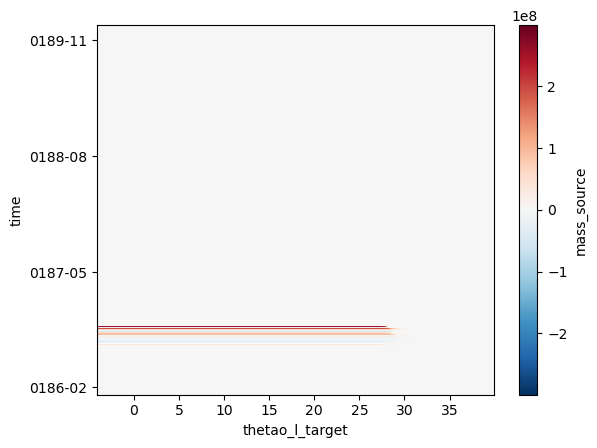

In [64]:
wmt25.mass_source.plot()